In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

In [12]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import tensorflow as tf

import jax
import jax.numpy as jnp
from jax import jit, grad, lax, random, vmap
from jax.example_libraries import optimizers
from jax.example_libraries import stax
from jax.example_libraries.stax import Dense, Relu, Sigmoid
from functools import partial 

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# SIREN Network Implementation
def init_siren_params(layer_widths, rng_key, omega_0=5.0):
    """
    Initialize parameters for SIREN network with proper initialization.
    
    Args:
        layer_widths: List of layer widths [input_dim, hidden1, hidden2, ..., output_dim]
        rng_key: JAX random key
        omega_0: Frequency parameter for SIREN
    
    Returns:
        List of [weight, bias] pairs for each layer
    """
    params = []
    keys = random.split(rng_key, len(layer_widths) - 1)
    
    for i, (n_in, n_out) in enumerate(zip(layer_widths[:-1], layer_widths[1:])):
        weight_key, bias_key = random.split(keys[i])
        
        if i == 0:  # First layer - first_layer_sine_init
            # First layer weights: uniform over [-1/n_in, 1/n_in]
            weights = random.uniform(
                weight_key, 
                shape=(n_in, n_out),
                minval=-1/n_in, 
                maxval=1/n_in
            )
        else:  # Hidden layers - sine_init with omega_0
            # Hidden layer weights: uniform over [-sqrt(6/n_in)/omega_0, sqrt(6/n_in)/omega_0]
            bound = jnp.sqrt(6/n_in) / omega_0
            weights = random.uniform(
                weight_key, 
                shape=(n_in, n_out),
                minval=-bound, 
                maxval=bound
            )
        
        # All biases are zeros
        biases = jnp.zeros((n_out,))
        params.append([weights, biases])
    
    return params

def siren_forward(x_input, params, omega_0=5.0):
    """
    Forward pass for SIREN network.
    
    Args:
        x_input: Input vector
        params: List of [weight, bias] pairs
        omega_0: Frequency parameter
    
    Returns:
        Output of the network
    """
    x = x_input
    
    # First layer with sine activation and omega_0
    x = jnp.sin(omega_0 * (x @ params[0][0] + params[0][1]))
    
    # Hidden layers with sine activation and omega_0
    for i in range(1, len(params)-1):
        x = jnp.sin(omega_0 * (x @ params[i][0] + params[i][1]))
    
    # Output layer (no sine activation, no omega_0 scaling)
    output = (x @ params[-1][0]) + params[-1][1]
    
    return output

# Vectorized SIREN forward pass
siren_forward_batch = jax.jit(vmap(siren_forward, in_axes=(0, None, None)))

def get_siren_coordinates(latent_dim):
    """
    Generate coordinate inputs for SIREN network.
    Maps i -> x_i where x_i = (2*i/latent_dim - 1) to get range [-1, 1]
    """
    indices = jnp.arange(1, latent_dim + 1)  # 1 to latent_dim
    coordinates = 2.0 * indices / latent_dim - 1.0  # Scale to [-1, 1]
    return coordinates.reshape(-1, 1)  # Shape: (latent_dim, 1)

class SIRENAutoencoder:
    def __init__(self, latent_dim=64, hidden_dims=[512, 256, 128], 
                 siren_hidden_dims=[64, 64], omega_0=5.0):
        """
        SIREN-based autoencoder for MNIST compression.
        
        Args:
            latent_dim: Dimension of the latent space (output of SIREN)
            hidden_dims: List of hidden layer dimensions for encoder/decoder
            siren_hidden_dims: Hidden dimensions for SIREN network
            omega_0: Frequency parameter for SIREN activations
        """
        self.latent_dim = latent_dim
        self.hidden_dims = hidden_dims
        self.siren_hidden_dims = siren_hidden_dims
        self.omega_0 = omega_0
        
        # SIREN network architecture: input_dim=1, output_dim=1
        self.siren_layers = [1] + siren_hidden_dims + [1]
        
        # Calculate total number of SIREN parameters
        self.siren_param_count = self._count_siren_params()
        
        # Generate coordinate inputs for SIREN
        self.siren_coords = get_siren_coordinates(latent_dim)
        
        self.setup_networks()
        
    def _count_siren_params(self):
        """Count total number of parameters in SIREN network."""
        total_params = 0
        for i in range(len(self.siren_layers) - 1):
            n_in, n_out = self.siren_layers[i], self.siren_layers[i+1]
            total_params += n_in * n_out + n_out  # weights + biases
        return total_params
        
    def setup_networks(self):
        """Initialize encoder and decoder networks."""
        # Build encoder layers - output SIREN parameters
        encoder_layers = []
        for hidden_dim in self.hidden_dims:
            encoder_layers.extend([Dense(hidden_dim), Relu])
        # Final layer outputs SIREN parameters
        encoder_layers.append(Dense(self.siren_param_count))
        
        self.encoder_init, self.encode_to_siren_params = stax.serial(*encoder_layers)
        
        # Build decoder layers (same as original)
        decoder_layers = []
        for hidden_dim in reversed(self.hidden_dims):
            decoder_layers.extend([Dense(hidden_dim), Relu])
        # Final layer to reconstruct input
        decoder_layers.extend([Dense(28 * 28), Sigmoid])
        
        self.decoder_init, self.decode = stax.serial(*decoder_layers)
    
    def _unflatten_siren_params(self, flat_params):
        """Convert flat parameter vector to SIREN network structure."""
        params = []
        idx = 0
        
        for i in range(len(self.siren_layers) - 1):
            n_in, n_out = self.siren_layers[i], self.siren_layers[i+1]
            
            # Extract weights
            weight_size = n_in * n_out
            weights = flat_params[idx:idx + weight_size].reshape(n_in, n_out)
            idx += weight_size
            
            # Extract biases
            biases = flat_params[idx:idx + n_out]
            idx += n_out
            
            params.append([weights, biases])
        
        return params
    
    def encode_to_latent(self, enc_params, images):
        """
        Encode images to latent space via SIREN network.
        
        Args:
            enc_params: Encoder parameters
            images: Input images
            
        Returns:
            Latent codes from SIREN network
        """
        # Get SIREN parameters from encoder
        flat_siren_params = self.encode_to_siren_params(enc_params, images)
        
        # Process each image separately
        def process_single_image(single_flat_params):
            # Unflatten SIREN parameters
            siren_params = self._unflatten_siren_params(single_flat_params)
            
            # Generate latent codes using SIREN
            latent_codes = []
            for coord in self.siren_coords:
                latent_value = siren_forward(coord, siren_params, self.omega_0)
                latent_codes.append(latent_value[0])  # Extract scalar value
            
            return jnp.array(latent_codes)
        
        # Vectorize over batch
        latent_codes = vmap(process_single_image)(flat_siren_params)
        return latent_codes
    
    def reconstruction_loss(self, params, images):
        """Mean squared error reconstruction loss."""
        enc_params, dec_params = params
        # Encode to latent space via SIREN
        latent_code = self.encode_to_latent(enc_params, images)
        # Decode back to image space
        reconstructed = self.decode(dec_params, latent_code)
        # MSE loss
        return jnp.mean(jnp.sum((images - reconstructed) ** 2, axis=1))
    
    def binary_crossentropy_loss(self, params, images):
        """Binary cross-entropy reconstruction loss."""
        enc_params, dec_params = params
        latent_code = self.encode_to_latent(enc_params, images)
        reconstructed = self.decode(dec_params, latent_code)
        
        # Clamp to avoid log(0)
        reconstructed = jnp.clip(reconstructed, 1e-7, 1.0 - 1e-7)
        
        # Binary cross-entropy
        bce = -(images * jnp.log(reconstructed) + (1 - images) * jnp.log(1 - reconstructed))
        return jnp.mean(jnp.sum(bce, axis=1))
    
    def reconstruct_images(self, params, images):
        """Reconstruct images through the SIREN autoencoder."""
        enc_params, dec_params = params
        latent_code = self.encode_to_latent(enc_params, images)
        reconstructed = self.decode(dec_params, latent_code)
        return reconstructed
    
    def encode_images(self, params, images):
        """Encode images to latent space."""
        enc_params, _ = params
        return self.encode_to_latent(enc_params, images)
    
    def decode_latent(self, params, latent_codes):
        """Decode latent codes to images."""
        _, dec_params = params
        return self.decode(dec_params, latent_codes)
    
    def get_compression_ratio(self):
        """Calculate compression ratio."""
        original_size = 28 * 28  # 784 pixels
        # Compressed representation is the SIREN parameters
        compressed_size = self.siren_param_count
        compression_ratio = original_size / compressed_size
        return compression_ratio
    
    def create_image_grid(self, nrow, ncol, imagevecs, imshape=(28, 28)):
        """Create a grid of images for visualization."""
        images = iter(imagevecs.reshape((-1,) + imshape))
        return jnp.vstack([
            jnp.hstack([next(images).T for _ in range(ncol)][::-1])
            for _ in range(nrow)
        ]).T

class Trainer:
    def __init__(self, model, step_size=0.001, momentum=0.9, loss_type='mse'):
        """
        Args:
            loss_type: 'mse' for mean squared error or 'bce' for binary cross-entropy
        """
        self.model = model
        self.loss_type = loss_type
        self.opt_init, self.opt_update, self.get_params = optimizers.momentum(
            step_size, mass=momentum
        )
        self.history = {
            'train_loss': [],
            'test_loss': []
        }
        
        # Choose loss function
        if loss_type == 'mse':
            self.loss_fn = model.reconstruction_loss
        elif loss_type == 'bce':
            self.loss_fn = model.binary_crossentropy_loss
        else:
            raise ValueError("loss_type must be 'mse' or 'bce'")
        
    @partial(jax.jit, static_argnames=['self'])
    def train_step(self, opt_state, batch):
        """Single training step."""
        params = self.get_params(opt_state)
        loss, grads = jax.value_and_grad(self.loss_fn)(params, batch)
        opt_state = self.opt_update(0, grads, opt_state)
        return opt_state, loss
    
    def train_epoch(self, opt_state, images, batch_size):
        """Train for one epoch."""
        num_batches = (images.shape[0] + batch_size - 1) // batch_size
        total_loss = 0.0
        
        # Shuffle data
        rng = random.key(int(time.time()))
        perm = random.permutation(rng, images.shape[0])
        images_shuffled = images[perm]
        
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, images.shape[0])
            batch = images_shuffled[start_idx:end_idx]
            
            opt_state, loss = self.train_step(opt_state, batch)
            total_loss += loss
        
        return opt_state, total_loss / num_batches
    
    @partial(jax.jit, static_argnames=['self'])
    def evaluate(self, opt_state, images, batch_size=1000):
        """Evaluate the model."""
        params = self.get_params(opt_state)
        total_loss = 0.0
        num_batches = (images.shape[0] + batch_size - 1) // batch_size
        
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, images.shape[0])
            batch = images[start_idx:end_idx]
            
            loss = self.loss_fn(params, batch)
            total_loss += loss * batch.shape[0]
        
        return total_loss / images.shape[0]

class Visualizer:
    def __init__(self, model):
        self.model = model
    
    def plot_training_history(self, history, save_path=None):
        """Plot training history."""
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
        
        ax.plot(history['train_loss'], 'b-', alpha=0.8, label='Training Loss')
        ax.plot(history['test_loss'], 'r-', alpha=0.8, label='Test Loss')
        ax.set_title('SIREN Autoencoder Training History', fontsize=16)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Reconstruction Loss')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_reconstructions(self, params, test_images, num_examples=10, save_path=None):
        """Plot original vs reconstructed images."""
        # Select random images
        indices = np.random.choice(test_images.shape[0], num_examples, replace=False)
        original_images = test_images[indices]
        reconstructed = self.model.reconstruct_images(params, original_images)
        
        fig, axes = plt.subplots(2, num_examples, figsize=(20, 4))
        fig.suptitle('Original vs SIREN Reconstructed Images', fontsize=16)
        
        for i in range(num_examples):
            # Original images
            axes[0, i].imshow(original_images[i].reshape(28, 28), cmap='gray')
            axes[0, i].set_title(f'Original {i+1}')
            axes[0, i].axis('off')
            
            # Reconstructed images
            axes[1, i].imshow(reconstructed[i].reshape(28, 28), cmap='gray')
            axes[1, i].set_title(f'SIREN Recon {i+1}')
            axes[1, i].axis('off')
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_siren_functions(self, params, test_images, num_examples=5, save_path=None):
        """Visualize SIREN functions for different images."""
        # Select random images
        indices = np.random.choice(test_images.shape[0], num_examples, replace=False)
        selected_images = test_images[indices]
        
        # Get encoder parameters
        enc_params, _ = params
        
        # Get SIREN parameters for selected images
        flat_siren_params = self.model.encode_to_siren_params(enc_params, selected_images)
        
        # Create fine-grained coordinate inputs for visualization
        coords_fine = jnp.linspace(-1, 1, 200).reshape(-1, 1)
        
        fig, axes = plt.subplots(1, num_examples, figsize=(20, 4))
        fig.suptitle('SIREN Functions for Different Images', fontsize=16)
        
        for i in range(num_examples):
            # Unflatten SIREN parameters
            siren_params = self.model._unflatten_siren_params(flat_siren_params[i])
            
            # Evaluate SIREN over fine coordinates
            siren_outputs = []
            for coord in coords_fine:
                output = siren_forward(coord, siren_params, self.model.omega_0)
                siren_outputs.append(output[0])
            
            siren_outputs = jnp.array(siren_outputs)
            
            # Plot SIREN function
            axes[i].plot(coords_fine.flatten(), siren_outputs, 'b-', linewidth=2)
            axes[i].set_title(f'SIREN Function {i+1}')
            axes[i].set_xlabel('Coordinate')
            axes[i].set_ylabel('Output')
            axes[i].grid(True, alpha=0.3)
            axes[i].set_xlim(-1, 1)
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    
    def analyze_compression(self, params, test_images, num_samples=100):
        """Analyze compression quality and statistics."""
        # Select random samples
        indices = np.random.choice(test_images.shape[0], num_samples, replace=False)
        sample_images = test_images[indices]
        
        # Get reconstructions
        reconstructed = self.model.reconstruct_images(params, sample_images)
        
        # Calculate metrics
        mse_per_image = jnp.mean((sample_images - reconstructed) ** 2, axis=1)
        mean_mse = jnp.mean(mse_per_image)
        std_mse = jnp.std(mse_per_image)
        
        # Calculate PSNR
        psnr_per_image = 20 * jnp.log10(1.0 / jnp.sqrt(mse_per_image))
        mean_psnr = jnp.mean(psnr_per_image)
        
        compression_ratio = self.model.get_compression_ratio()
        
        print("=" * 50)
        print("SIREN AUTOENCODER COMPRESSION ANALYSIS")
        print("=" * 50)
        print(f"Latent Dimension: {self.model.latent_dim}")
        print(f"SIREN Parameters: {self.model.siren_param_count}")
        print(f"SIREN Architecture: {self.model.siren_layers}")
        print(f"Omega_0: {self.model.omega_0}")
        print(f"Compression Ratio: {compression_ratio:.2f}:1")
        print(f"Original Size: {28*28} pixels")
        print(f"Compressed Size: {self.model.siren_param_count} SIREN params")
        print(f"Mean MSE: {mean_mse:.6f} ± {std_mse:.6f}")
        print(f"Mean PSNR: {mean_psnr:.2f} dB")
        print("=" * 50)

def load_mnist_data():
    """Load MNIST data using TensorFlow and convert to JAX format."""
    # Load MNIST dataset from TensorFlow
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    
    # Normalize pixel values to [0, 1]
    x_train = x_train.astype(np.float32) / 255.0
    x_test = x_test.astype(np.float32) / 255.0
    
    # Flatten images to vectors
    x_train = x_train.reshape(x_train.shape[0], -1)  # (60000, 784)
    x_test = x_test.reshape(x_test.shape[0], -1)     # (10000, 784)
    
    # Convert to JAX arrays
    x_train = jnp.array(x_train)
    x_test = jnp.array(x_test)
    y_train = jnp.array(y_train)
    y_test = jnp.array(y_test)
    
    print(f"Training data shape: {x_train.shape}")
    print(f"Test data shape: {x_test.shape}")
    print(f"Training labels shape: {y_train.shape}")
    print(f"Test labels shape: {y_test.shape}")
    
    return x_train, y_train, x_test, y_test


# Hyperparameters
step_size = 0.001
num_epochs = 500
batch_size = 64
latent_dim = 64  # Output dimension of SIREN
hidden_dims = [512, 256, 128]  # Encoder/decoder architecture
siren_hidden_dims = [128]  # SIREN network architecture
omega_0 = 5.0  # SIREN frequency parameter
loss_type = 'mse'  # 'mse' or 'bce'

# Initialize model and trainer
model = SIRENAutoencoder(
    latent_dim=latent_dim, 
    hidden_dims=hidden_dims,
    siren_hidden_dims=siren_hidden_dims,
    omega_0=omega_0
)
trainer = Trainer(model, step_size=step_size, loss_type=loss_type)
visualizer = Visualizer(model)

print(f"SIREN compression ratio: {model.get_compression_ratio():.2f}:1")
print(f"SIREN parameter count: {model.siren_param_count}")

# Load data
print("Loading MNIST data...")
train_images, train_labels, test_images, test_labels = load_mnist_data()

# Move data to device
train_images = jax.device_put(train_images)
test_images = jax.device_put(test_images)

# Initialize parameters
print("Initializing parameters...")
enc_init_rng, dec_init_rng = random.split(random.key(42))
_, init_encoder_params = model.encoder_init(enc_init_rng, (batch_size, 28 * 28))
_, init_decoder_params = model.decoder_init(dec_init_rng, (batch_size, latent_dim))
init_params = init_encoder_params, init_decoder_params

opt_state = trainer.opt_init(init_params)

# Training loop
print("Starting SIREN autoencoder training...")
for epoch in range(num_epochs):
    tic = time.time()
    
    # Train
    opt_state, train_loss = trainer.train_epoch(opt_state, train_images, batch_size)
    
    # Evaluate
    test_loss = trainer.evaluate(opt_state, test_images)
    
    # Store history
    trainer.history['train_loss'].append(float(train_loss))
    trainer.history['test_loss'].append(float(test_loss))
    
    # Print progress
    elapsed = time.time() - tic
    print(f"Epoch {epoch:3d} | Train Loss: {train_loss:.6f} | "
            f"Test Loss: {test_loss:.6f} | Time: {elapsed:.2f}s")

# Final visualizations and analysis
print("\nTraining completed! Generating visualizations...")
final_params = trainer.get_params(opt_state)



SIREN compression ratio: 2.04:1
SIREN parameter count: 385
Loading MNIST data...
Training data shape: (60000, 784)
Test data shape: (10000, 784)
Training labels shape: (60000,)
Test labels shape: (10000,)
Initializing parameters...
Starting SIREN autoencoder training...
Epoch   0 | Train Loss: 33.125187 | Test Loss: 22.669460 | Time: 19.06s
Epoch   1 | Train Loss: 20.256844 | Test Loss: 18.194061 | Time: 0.37s
Epoch   2 | Train Loss: 17.658714 | Test Loss: 16.727362 | Time: 0.38s
Epoch   3 | Train Loss: 15.979730 | Test Loss: 15.287945 | Time: 0.36s
Epoch   4 | Train Loss: 14.699211 | Test Loss: 13.936453 | Time: 0.37s
Epoch   5 | Train Loss: 13.797200 | Test Loss: 14.060929 | Time: 0.37s
Epoch   6 | Train Loss: 13.130455 | Test Loss: 13.099267 | Time: 0.37s
Epoch   7 | Train Loss: 12.628283 | Test Loss: 12.860702 | Time: 0.38s
Epoch   8 | Train Loss: 12.180964 | Test Loss: 12.084914 | Time: 0.37s
Epoch   9 | Train Loss: 11.822736 | Test Loss: 11.834156 | Time: 0.37s
Epoch  10 | Train 

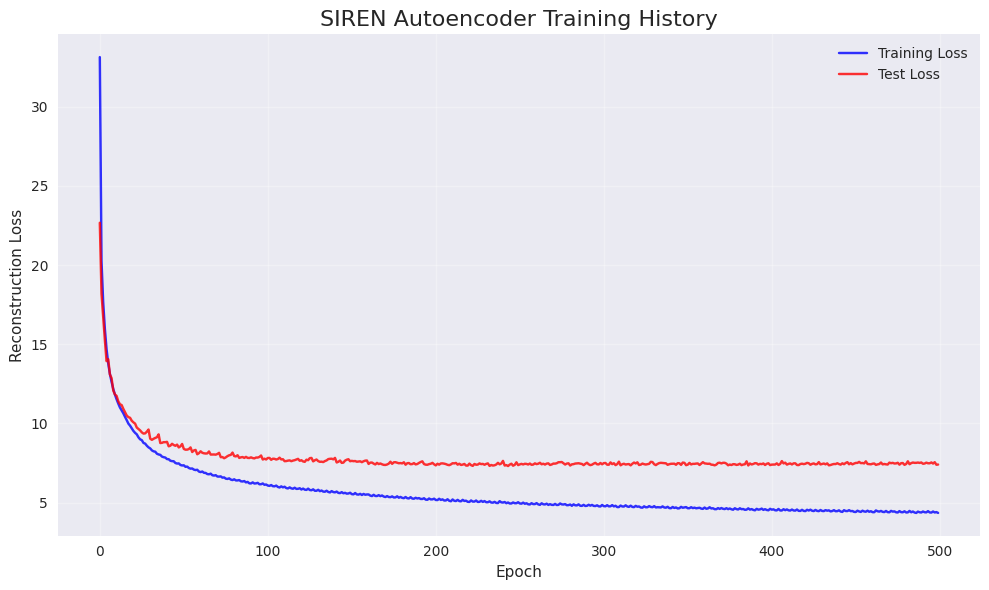

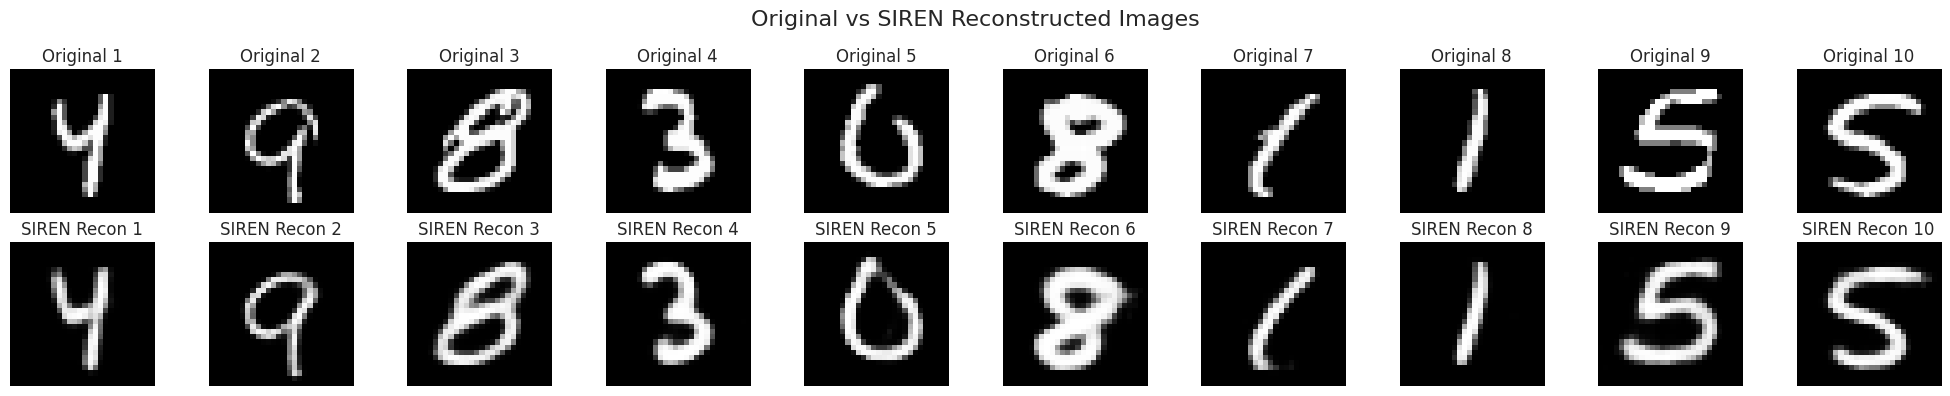

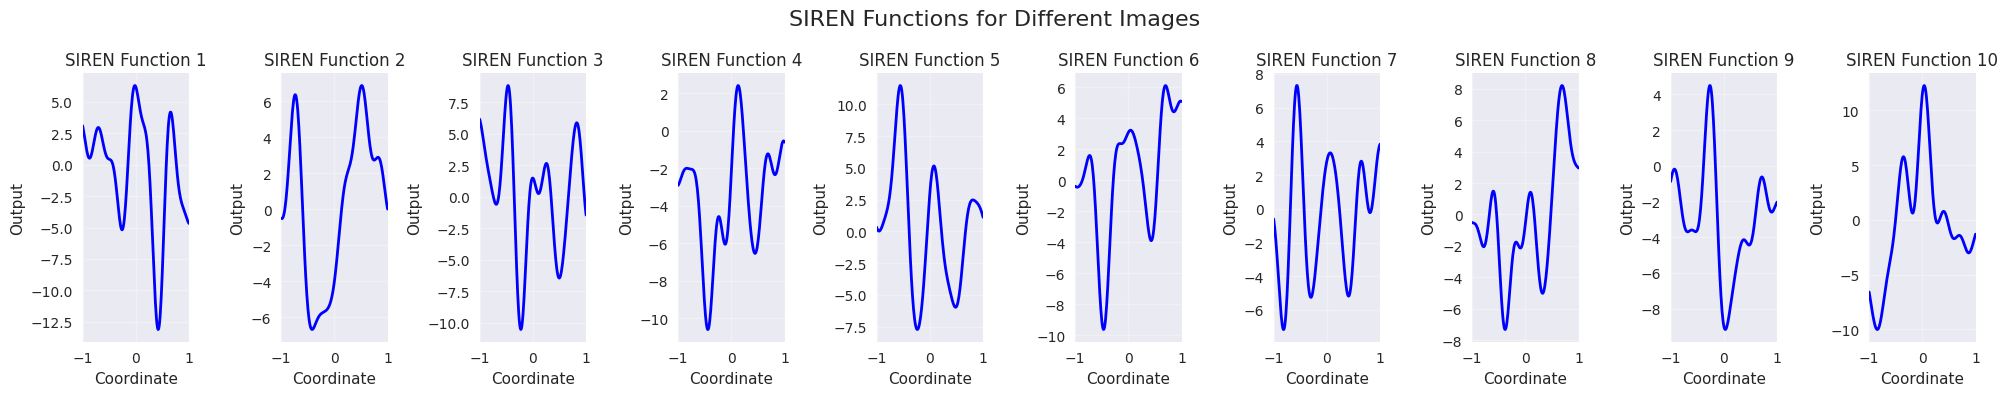

SIREN AUTOENCODER COMPRESSION ANALYSIS
Latent Dimension: 64
SIREN Parameters: 385
SIREN Architecture: [1, 128, 1]
Omega_0: 5.0
Compression Ratio: 2.04:1
Original Size: 784 pixels
Compressed Size: 385 SIREN params
Mean MSE: 0.009435 ± 0.006671
Mean PSNR: 21.36 dB
All visualizations complete!


In [13]:
# Plot training history
visualizer.plot_training_history(trainer.history)

# Plot reconstructions
visualizer.plot_reconstructions(final_params, test_images, num_examples=10)

# Plot SIREN functions
visualizer.plot_siren_functions(final_params, test_images, num_examples=10)

# Analyze compression performance
visualizer.analyze_compression(final_params, test_images, num_samples=1000)

print("All visualizations complete!")

## all number 4

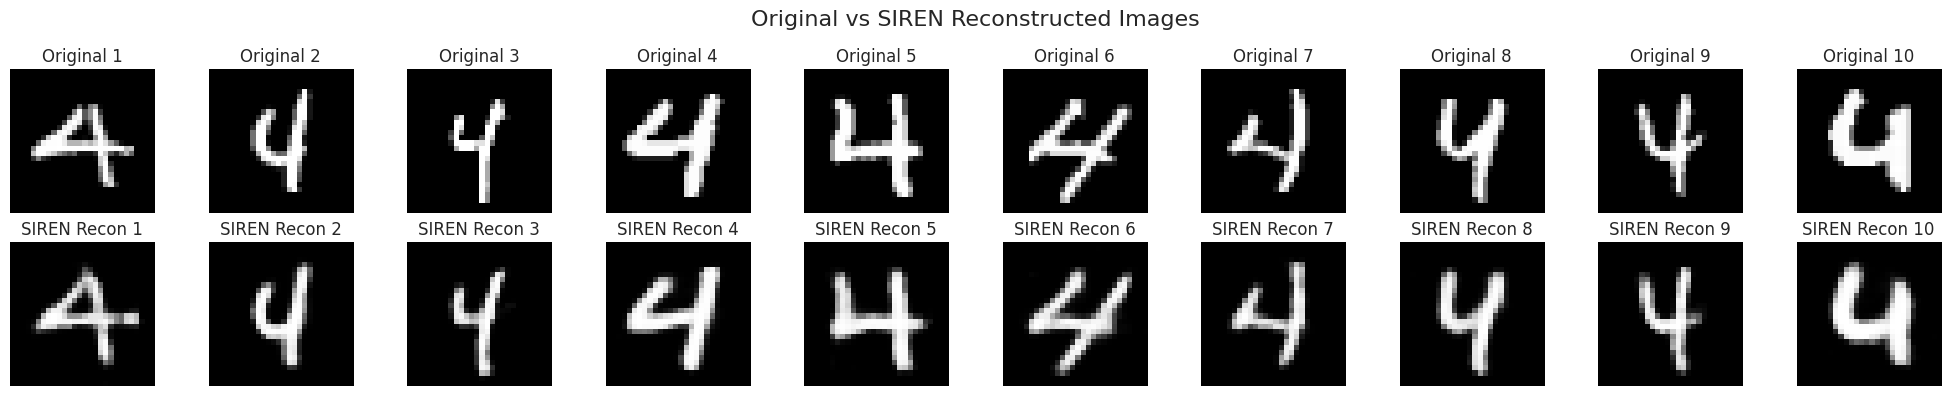

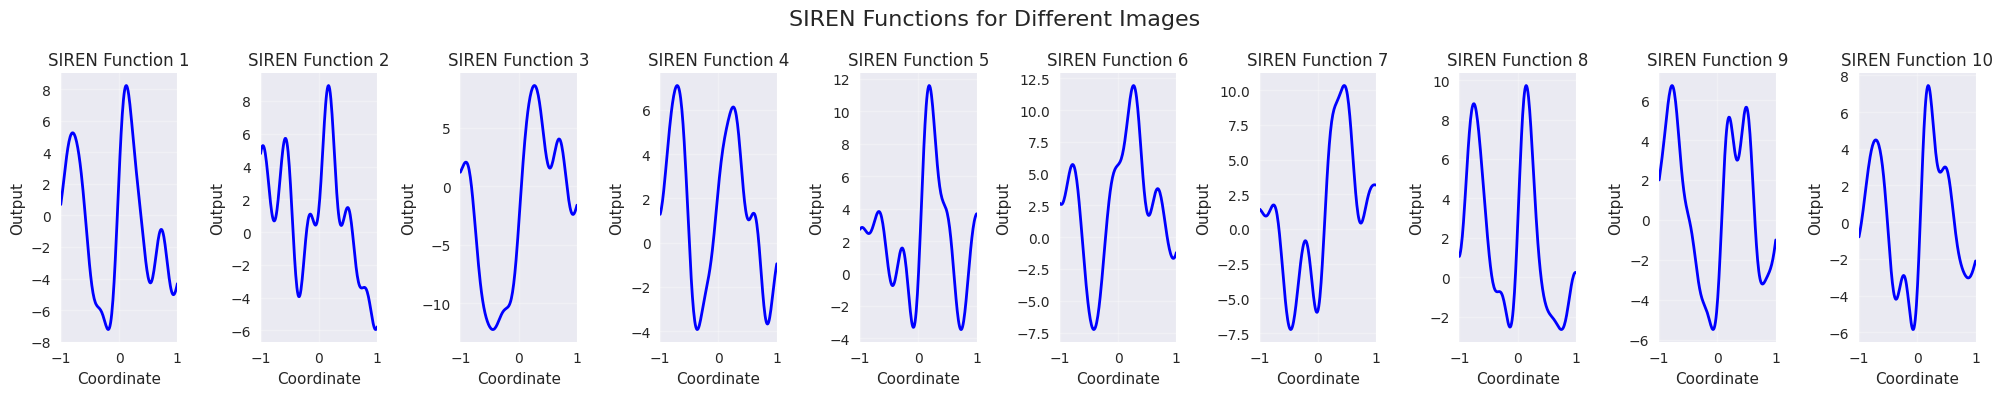

In [14]:
test_images_digit_4 = test_images[test_labels == 4]

# Plot reconstructions
visualizer.plot_reconstructions(final_params, test_images_digit_4, num_examples=10)

# Plot SIREN functions
visualizer.plot_siren_functions(final_params, test_images_digit_4, num_examples=10)

# Other numbers 

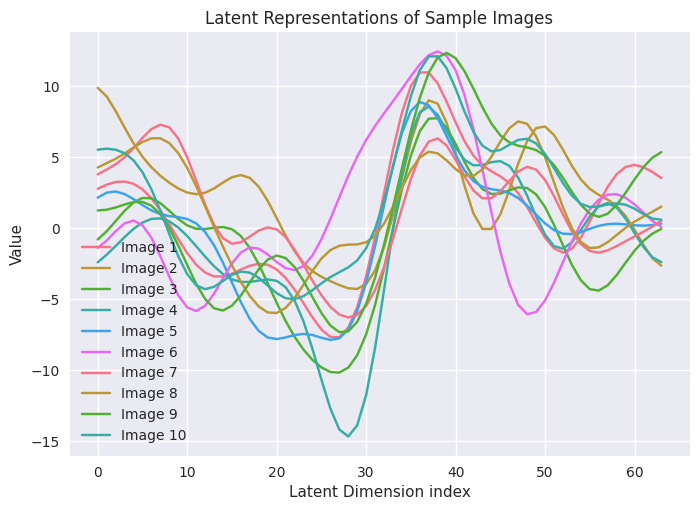

In [20]:
test_images_digit_4 = test_images[test_labels == 4]

for i in range(10):
    plt.plot(np.arange(latent_dim), model.encode_images(final_params, test_images_digit_4)[i,...], label=f'Image {i+1}')
plt.title('Latent Representations of Sample Images')
plt.xlabel('Latent Dimension index')
plt.ylabel('Value')
plt.legend()

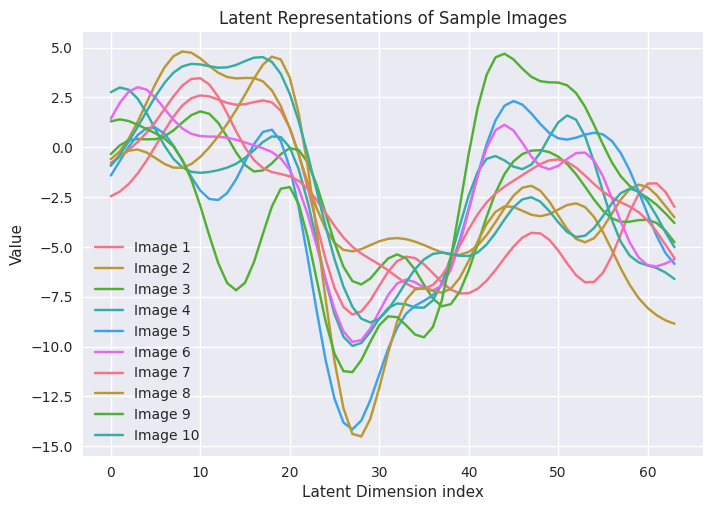

In [26]:
test_images_digit_1 = test_images[test_labels == 1]

for i in range(10):
    plt.plot(np.arange(latent_dim), model.encode_images(final_params, test_images_digit_1)[i,...], label=f'Image {i+1}')
plt.title('Latent Representations of Sample Images')
plt.xlabel('Latent Dimension index')
plt.ylabel('Value')
plt.legend()

#  svd analysis

In [ ]:
latent_data = model.encode_images(final_params, test_images)
np.linalg.svd(latent_data, full_matrices=False)

Latent data shape: (10000, 64)
U shape: (10000, 64)
Singular values shape: (64,)
V transpose shape: (64, 64)


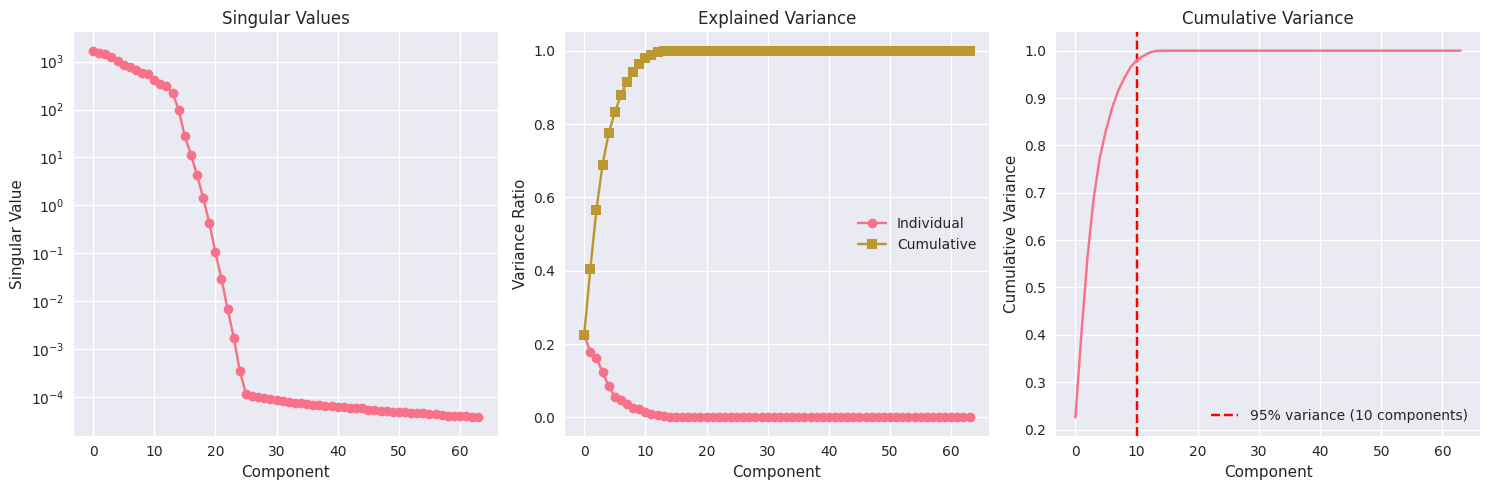


SVD Analysis Results:
Total components: 64
Components for 90% variance: 8
Components for 95% variance: 10
Components for 99% variance: 13
Effective dimensionality: 12.55
Reconstruction error with 10 components: 0.689468
Reconstruction error with 50 components: 0.000000
Reconstruction error with 64 components: 0.000000


In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Encode your test images to latent space
latent_data = model.encode_images(final_params, test_images)
print(f"Latent data shape: {latent_data.shape}")

# Perform SVD
U, s, Vt = np.linalg.svd(latent_data, full_matrices=False)

print(f"U shape: {U.shape}")
print(f"Singular values shape: {s.shape}")
print(f"V transpose shape: {Vt.shape}")

# Analyze the singular values
plt.figure(figsize=(15, 5))

# Plot 1: Singular values
plt.subplot(1, 3, 1)
plt.plot(s, 'o-')
plt.title('Singular Values')
plt.xlabel('Component')
plt.ylabel('Singular Value')
plt.yscale('log')

# Plot 2: Explained variance ratio
variance_explained = (s**2) / np.sum(s**2)
cumulative_variance = np.cumsum(variance_explained)

plt.subplot(1, 3, 2)
plt.plot(variance_explained, 'o-', label='Individual')
plt.plot(cumulative_variance, 's-', label='Cumulative')
plt.title('Explained Variance')
plt.xlabel('Component')
plt.ylabel('Variance Ratio')
plt.legend()

# Plot 3: Effective dimensionality
plt.subplot(1, 3, 3)
# Find components that explain 95% of variance
n_components_95 = np.where(cumulative_variance >= 0.95)[0][0] + 1
plt.axvline(n_components_95, color='red', linestyle='--', 
           label=f'95% variance ({n_components_95} components)')
plt.plot(cumulative_variance)
plt.title('Cumulative Variance')
plt.xlabel('Component')
plt.ylabel('Cumulative Variance')
plt.legend()

plt.tight_layout()
plt.show()

# Print key statistics
print(f"\nSVD Analysis Results:")
print(f"Total components: {len(s)}")
print(f"Components for 90% variance: {np.where(cumulative_variance >= 0.90)[0][0] + 1}")
print(f"Components for 95% variance: {n_components_95}")
print(f"Components for 99% variance: {np.where(cumulative_variance >= 0.99)[0][0] + 1}")

# Effective dimensionality (using entropy-based measure)
normalized_s = s / np.sum(s)
effective_dim = np.exp(-np.sum(normalized_s * np.log(normalized_s + 1e-12)))
print(f"Effective dimensionality: {effective_dim:.2f}")

# Dimensionality reduction example
def reconstruct_with_k_components(k):
    """Reconstruct data using only first k components"""
    return U[:, :k] @ np.diag(s[:k]) @ Vt[:k, :]

# Example: reconstruct with different numbers of components
k_values = [10, 50, 100, min(200, len(s))]
reconstruction_errors = []

for k in k_values:
    if k <= len(s):
        reconstructed = reconstruct_with_k_components(k)
        error = np.mean((latent_data - reconstructed)**2)
        reconstruction_errors.append(error)
        print(f"Reconstruction error with {k} components: {error:.6f}")

